In [1]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv
from ogb.nodeproppred import PygNodePropPredDataset, Evaluator
from torch_geometric.loader import NeighborLoader
import torch_geometric.data.data
import torch_geometric.data.storage
from torch_geometric.utils import to_networkx, k_hop_subgraph
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import seaborn as sns

torch.serialization.add_safe_globals([
    torch_geometric.data.data.DataEdgeAttr,
    torch_geometric.data.data.DataTensorAttr,
    torch_geometric.data.storage.GlobalStorage
])

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)


/home/karthiksoman/miniconda3/envs/gnn-pyg/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/karthiksoman/miniconda3/envs/gnn-pyg/lib/python3.13/site-packages/outdated/__init__.py:36: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import parse_version



## Part 1: Dataset Loading and Model Creation


## Load Dataset

In [2]:
# Load the ogbn-products dataset
dataset = PygNodePropPredDataset(name='ogbn-products')
data = dataset[0]
split_idx = dataset.get_idx_split()

print(f"Dataset: {dataset.name}")
print(f"Number of nodes: {data.num_nodes:,}")
print(f"Number of edges: {data.num_edges:,}")
print(f"Number of node features: {data.x.shape[1]}")
print(f"Number of classes: {dataset.num_classes}")
print(f"\nMemory usage:")
print(f"Node features: {data.x.element_size() * data.x.nelement() / 1e9:.2f} GB")
print(f"Edge index: {data.edge_index.element_size() * data.edge_index.nelement() / 1e9:.2f} GB")
print(f"\nSplit sizes:")
print(f"Train: {len(split_idx['train']):,}")
print(f"Validation: {len(split_idx['valid']):,}")
print(f"Test: {len(split_idx['test']):,}")

Dataset: ogbn-products
Number of nodes: 2,449,029
Number of edges: 123,718,280
Number of node features: 100
Number of classes: 47

Memory usage:
Node features: 0.98 GB
Edge index: 1.98 GB

Split sizes:
Train: 196,615
Validation: 39,323
Test: 2,213,091


## Custom GraphSAGE Model

In [3]:
class GraphSAGE(torch.nn.Module):
    """Custom GraphSAGE model for node classification.
    
    This is a Message Passing Graph Neural Network (MP-GNN) that uses
    the SAGE aggregation scheme.
    """
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers, dropout=0.5):
        super().__init__()
        self.num_layers = num_layers
        self.convs = torch.nn.ModuleList()
        self.dropout = dropout
        
        # Input layer
        self.convs.append(SAGEConv(in_channels, hidden_channels))
        
        # Hidden layers
        for _ in range(num_layers - 2):
            self.convs.append(SAGEConv(hidden_channels, hidden_channels))
        
        # Output layer
        self.convs.append(SAGEConv(hidden_channels, out_channels))
    
    def forward(self, x, edge_index):
        """Forward pass through the network."""
        for i, conv in enumerate(self.convs):
            x = conv(x, edge_index)
            if i < self.num_layers - 1:
                x = F.relu(x)
                x = F.dropout(x, p=self.dropout, training=self.training)
        return x
    
    def get_embeddings(self, x, edge_index):
        """Get node embeddings from the penultimate layer."""
        for i, conv in enumerate(self.convs[:-1]):
            x = conv(x, edge_index)
            if i < len(self.convs) - 2:
                x = F.relu(x)
                x = F.dropout(x, p=self.dropout, training=self.training)
        return x

print("Model defined successfully!")

Model defined successfully!


## Set Hyperparameters

In [4]:
# Model Hyperparameters
NUMBER_OF_LAYERS = 2
NEIGHBOR_SAMPLES = [10, 5]
HIDDEN_LAYER_DIMENSION = 256

# Training Hyperparameters
NUMBER_OF_EPOCHS = 25
BATCH_SIZE = 1024
DROPOUT_P = 0.5
LEARNING_RATE = 0.003
WORKER_COUNT = 0

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


## Initialize Model

In [5]:
model = GraphSAGE(
    in_channels=data.x.shape[1],
    hidden_channels=HIDDEN_LAYER_DIMENSION,
    out_channels=dataset.num_classes,
    num_layers=NUMBER_OF_LAYERS,
    dropout=DROPOUT_P
).to(device)

print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"\nModel architecture:\n{model}")

Model parameters: 75,567

Model architecture:
GraphSAGE(
  (convs): ModuleList(
    (0): SAGEConv(100, 256, aggr=mean)
    (1): SAGEConv(256, 47, aggr=mean)
  )
)


## Create Data Loaders

NeighborLoader performs mini-batch training by sampling subgraphs.
It keeps the full graph in CPU RAM but samples small subgraphs for each batch.

In [6]:
train_loader = NeighborLoader(
    data,
    num_neighbors=NEIGHBOR_SAMPLES,
    batch_size=BATCH_SIZE,
    input_nodes=split_idx['train'],
    num_workers=WORKER_COUNT,
    shuffle=True,
)

val_loader = NeighborLoader(
    data,
    num_neighbors=[-1],
    batch_size=BATCH_SIZE,
    input_nodes=split_idx['valid'],
    num_workers=WORKER_COUNT,
    shuffle=False,
)

test_loader = NeighborLoader(
    data,
    num_neighbors=[-1],
    batch_size=BATCH_SIZE,
    input_nodes=split_idx['test'],
    num_workers=WORKER_COUNT,
    shuffle=False,
)

print(f"Train batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")

Train batches: 193
Validation batches: 39
Test batches: 2162



## Part 2: Training and Evaluation using OGB Evaluator


## Initialize OGB Evaluator

In [7]:
# Initialize OGB evaluator for ogbn-products
evaluator = Evaluator(name='ogbn-products')

print("OGB Evaluator initialized!")
print(f"\nExpected input format:")
print(evaluator.expected_input_format)
print(f"\nExpected output format:")
print(evaluator.expected_output_format)

OGB Evaluator initialized!

Expected input format:
==== Expected input format of Evaluator for ogbn-products
{'y_true': y_true, 'y_pred': y_pred}
- y_true: numpy ndarray or torch tensor of shape (num_nodes num_tasks)
- y_pred: numpy ndarray or torch tensor of shape (num_nodes num_tasks)
where y_pred stores predicted class label (integer),
num_task is 1, and each row corresponds to one node.


Expected output format:
==== Expected output format of Evaluator for ogbn-products
{'acc': acc}
- acc (float): Accuracy score averaged across 1 task(s)



## Training and Testing Functions

In [8]:
def train(epoch):
    """Train the model for one epoch."""
    model.train()
    total_loss = 0
    y_true_list = []
    y_pred_list = []
    
    for batch in train_loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        
        # Forward pass
        out = model(batch.x, batch.edge_index)[:batch.batch_size]
        y = batch.y[:batch.batch_size].squeeze()
        
        # Compute loss
        loss = F.cross_entropy(out, y)
        loss.backward()
        optimizer.step()
        
        total_loss += float(loss) * batch.batch_size
        
        # Store predictions for OGB evaluation
        y_true_list.append(y.cpu().unsqueeze(1))
        y_pred_list.append(out.argmax(dim=-1, keepdim=True).cpu())
    
    # Compute accuracy using OGB evaluator
    y_true = torch.cat(y_true_list, dim=0)
    y_pred = torch.cat(y_pred_list, dim=0)
    
    input_dict = {"y_true": y_true, "y_pred": y_pred}
    result_dict = evaluator.eval(input_dict)
    
    return total_loss / len(split_idx['train']), result_dict['acc']

@torch.no_grad()
def test(loader, split_idx_key):
    """Evaluate the model using OGB evaluator."""
    model.eval()
    y_true_list = []
    y_pred_list = []
    
    for batch in loader:
        batch = batch.to(device)
        out = model(batch.x, batch.edge_index)[:batch.batch_size]
        y = batch.y[:batch.batch_size]
        
        y_true_list.append(y.cpu())
        y_pred_list.append(out.argmax(dim=-1, keepdim=True).cpu())
    
    # Concatenate all predictions
    y_true = torch.cat(y_true_list, dim=0)
    y_pred = torch.cat(y_pred_list, dim=0)
    
    # Evaluate using OGB evaluator
    input_dict = {"y_true": y_true, "y_pred": y_pred}
    result_dict = evaluator.eval(input_dict)
    
    return result_dict['acc']

# Initialize optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

print("Training functions defined!")

Training functions defined!


## Model Training

In [9]:
print("Training started...\n")

# Track metrics for plotting
train_losses = []
train_accs = []
val_accs = []

for epoch in range(1, NUMBER_OF_EPOCHS + 1):
    loss, train_acc = train(epoch)
    train_losses.append(loss)
    train_accs.append(train_acc)
    
    if epoch % 5 == 0:
        val_acc = test(val_loader, 'valid')
        val_accs.append(val_acc)
        print(f'Epoch {epoch:02d}: Loss={loss:.4f}, Train Acc={train_acc:.4f}, Val Acc={val_acc:.4f}')
    else:
        val_accs.append(val_accs[-1] if val_accs else 0.0)
        print(f'Epoch {epoch:02d}: Loss={loss:.4f}, Train Acc={train_acc:.4f}')

print("\nTraining completed!")

Training started...



/tmp/ipykernel_38464/570899821.py:21: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:835.)
  total_loss += float(loss) * batch.batch_size


Epoch 01: Loss=0.7448, Train Acc=0.8120
Epoch 02: Loss=0.4637, Train Acc=0.8764
Epoch 03: Loss=0.4306, Train Acc=0.8835
Epoch 04: Loss=0.4169, Train Acc=0.8867
Epoch 05: Loss=0.3965, Train Acc=0.8921, Val Acc=0.8556
Epoch 06: Loss=0.3951, Train Acc=0.8928
Epoch 07: Loss=0.3877, Train Acc=0.8950
Epoch 08: Loss=0.3827, Train Acc=0.8965
Epoch 09: Loss=0.3794, Train Acc=0.8969
Epoch 10: Loss=0.3804, Train Acc=0.8972, Val Acc=0.8518
Epoch 11: Loss=0.3785, Train Acc=0.8977
Epoch 12: Loss=0.3786, Train Acc=0.8972
Epoch 13: Loss=0.3827, Train Acc=0.8965
Epoch 14: Loss=0.3699, Train Acc=0.8995
Epoch 15: Loss=0.3647, Train Acc=0.9009, Val Acc=0.8512
Epoch 16: Loss=0.3634, Train Acc=0.9014
Epoch 17: Loss=0.3600, Train Acc=0.9014
Epoch 18: Loss=0.3663, Train Acc=0.9008
Epoch 19: Loss=0.3740, Train Acc=0.8993
Epoch 20: Loss=0.3608, Train Acc=0.9019, Val Acc=0.8472
Epoch 21: Loss=0.3707, Train Acc=0.9001
Epoch 22: Loss=0.3584, Train Acc=0.9029
Epoch 23: Loss=0.3610, Train Acc=0.9023
Epoch 24: Loss=0

## Final Test Evaluation

In [10]:
print("Evaluating on test set...")
test_acc = test(test_loader, 'test')
print(f'\nFinal Test Accuracy: {test_acc:.4f} ({test_acc*100:.2f}%)')

Evaluating on test set...

Final Test Accuracy: 0.6709 (67.09%)


## Plot Training Metrics

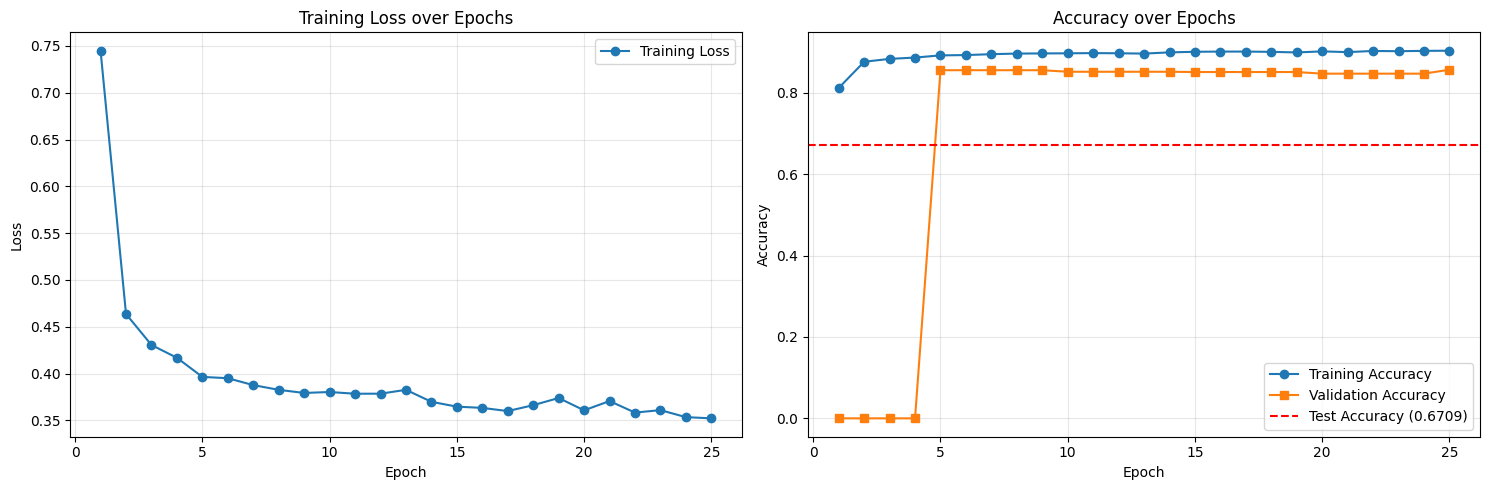

Training metrics plotted!


In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot loss
ax1.plot(range(1, NUMBER_OF_EPOCHS + 1), train_losses, marker='o', label='Training Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training Loss over Epochs')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot accuracy
ax2.plot(range(1, NUMBER_OF_EPOCHS + 1), train_accs, marker='o', label='Training Accuracy')
ax2.plot(range(1, NUMBER_OF_EPOCHS + 1), val_accs, marker='s', label='Validation Accuracy')
ax2.axhline(y=test_acc, color='r', linestyle='--', label=f'Test Accuracy ({test_acc:.4f})')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Accuracy over Epochs')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Training metrics plotted!")


## Part 3: Graph Analysis and Subgraph Generation


## Compute Graph Statistics

1. **Number of nodes and edges**
2. **Diameter**: The longest shortest path in the graph
3. **Global Clustering Coefficient**: Measures the degree to which nodes cluster together

In [17]:
print("Computing graph statistics...\n")

# Basic statistics
num_nodes = data.num_nodes
num_edges = data.num_edges

print(f"Number of nodes: {num_nodes:,}")
print(f"Number of edges: {num_edges:,}")
print(f"Average degree: {(2 * num_edges / num_nodes):.2f}")

print("\nNote: For the full graph (2.5M nodes), computing exact diameter and")
print("clustering coefficient is computationally expensive.")
print("We'll compute these metrics on a sampled subgraph.")

# Sample a connected subgraph
sample_size = 750
print(f"\nSampling {sample_size} nodes for statistics computation...")

# Create undirected networkx instance (ogbn-products is undirected)
edge_index_np = data.edge_index.numpy()
G_sample = nx.Graph()

# Start from a random node and grow a connected component
start_node = np.random.randint(0, num_nodes)
sampled_nodes = set([start_node])
frontier = [start_node]

while len(sampled_nodes) < sample_size and frontier:
    current = frontier.pop(0)
    # Find neighbors
    neighbors = edge_index_np[1, edge_index_np[0] == current]
    for neighbor in neighbors:
        if neighbor not in sampled_nodes and len(sampled_nodes) < sample_size:
            sampled_nodes.add(neighbor)
            frontier.append(neighbor)

# Build subgraph
sampled_nodes = list(sampled_nodes)
node_mask = torch.zeros(num_nodes, dtype=torch.bool)
node_mask[sampled_nodes] = True

# Get edges within sampled nodes
edge_mask = node_mask[data.edge_index[0]] & node_mask[data.edge_index[1]]
sampled_edges = data.edge_index[:, edge_mask]

# Create NetworkX graph
for i in range(sampled_edges.shape[1]):
    G_sample.add_edge(int(sampled_edges[0, i]), int(sampled_edges[1, i]))

print(f"Sampled subgraph: {G_sample.number_of_nodes()} nodes, {G_sample.number_of_edges()} edges")

# Get largest connected component
if not nx.is_connected(G_sample):
    print("Extracting largest connected component...")
    largest_cc = max(nx.connected_components(G_sample), key=len)
    G_sample = G_sample.subgraph(largest_cc).copy()
    print(f"Largest component: {G_sample.number_of_nodes()} nodes, {G_sample.number_of_edges()} edges")

# Compute statistics on sample
print("\nComputing statistics on sampled graph...")

# Diameter (expensive for large graphs)
diameter = nx.diameter(G_sample)
print(f"Diameter (sampled): {diameter}")

# Global Clustering Coefficient
clustering_coeff = nx.transitivity(G_sample)
print(f"Global Clustering Coefficient (sampled): {clustering_coeff:.6f}")

# Average clustering coefficient
avg_clustering = nx.average_clustering(G_sample)
print(f"Average Clustering Coefficient (sampled): {avg_clustering:.6f}")

print("\n" + "="*60)
print("SUMMARY OF GRAPH STATISTICS")
print("="*60)
print(f"Full Graph:")
print(f"  - Nodes: {num_nodes:,}")
print(f"  - Edges: {num_edges:,}")
print(f"  - Average Degree: {(2 * num_edges / num_nodes):.2f}")
print(f"\nSampled Subgraph ({G_sample.number_of_nodes()} nodes):")
print(f"  - Diameter: {diameter}")
print(f"  - Global Clustering Coefficient: {clustering_coeff:.6f}")
print(f"  - Average Clustering Coefficient: {avg_clustering:.6f}")
print("="*60)

Computing graph statistics...

Number of nodes: 2,449,029
Number of edges: 123,718,280
Average degree: 101.03

Note: For the full graph (2.5M nodes), computing exact diameter and
clustering coefficient is computationally expensive.
We'll compute these metrics on a sampled subgraph.

Sampling 750 nodes for statistics computation...
Sampled subgraph: 750 nodes, 21132 edges

Computing statistics on sampled graph...
Diameter (sampled): 4
Global Clustering Coefficient (sampled): 0.266115
Average Clustering Coefficient (sampled): 0.598097

SUMMARY OF GRAPH STATISTICS
Full Graph:
  - Nodes: 2,449,029
  - Edges: 123,718,280
  - Average Degree: 101.03

Sampled Subgraph (750 nodes):
  - Diameter: 4
  - Global Clustering Coefficient: 0.266115
  - Average Clustering Coefficient: 0.598097


## Generate Node-Induced Subgraph

Create node-induced subgraph centered around a randomly selected node.

In [18]:
print("Generating Node-Induced Subgraph...\n")

# Parameters for subgraph generation
CENTER_NODE = np.random.randint(0, num_nodes)
NUM_HOPS = 2  # 2-hop neighborhood
MAX_NODES = 750  # Limit subgraph size for computational efficiency

print(f"Center node: {CENTER_NODE}")
print(f"Center node category: {int(data.y[CENTER_NODE])}")
print(f"Extracting {NUM_HOPS}-hop neighborhood...")

# Extract k-hop subgraph
subset, sub_edge_index, mapping, edge_mask = k_hop_subgraph(
    node_idx=CENTER_NODE,
    num_hops=NUM_HOPS,
    edge_index=data.edge_index,
    num_nodes=num_nodes,
    relabel_nodes=False
)

print(f"Initial subgraph size: {len(subset)} nodes")

# Limit size if too large
if len(subset) > MAX_NODES:
    print(f"Limiting to {MAX_NODES} nodes...")
    # Keep center node and sample others
    center_idx = (subset == CENTER_NODE).nonzero(as_tuple=True)[0].item()
    other_indices = torch.cat([
        torch.arange(center_idx),
        torch.arange(center_idx + 1, len(subset))
    ])
    
    # Random sample
    perm = torch.randperm(len(other_indices))
    selected_other = other_indices[perm[:MAX_NODES-1]]
    selected_indices = torch.cat([torch.tensor([center_idx]), selected_other])
    
    subset = subset[selected_indices]
    
    # Update edges
    node_mask = torch.zeros(num_nodes, dtype=torch.bool)
    node_mask[subset] = True
    edge_mask = node_mask[sub_edge_index[0]] & node_mask[sub_edge_index[1]]
    sub_edge_index = sub_edge_index[:, edge_mask]

# Extract subgraph features and labels
subgraph_x = data.x[subset]
subgraph_y = data.y[subset]

# Create mapping from global node IDs to local node IDs
global_to_local = {int(global_id): local_id for local_id, global_id in enumerate(subset)}

# Relabel edges to local IDs
sub_edge_index_local = torch.zeros_like(sub_edge_index)
for i in range(sub_edge_index.shape[1]):
    src_global = int(sub_edge_index[0, i])
    dst_global = int(sub_edge_index[1, i])
    if src_global in global_to_local and dst_global in global_to_local:
        sub_edge_index_local[0, i] = global_to_local[src_global]
        sub_edge_index_local[1, i] = global_to_local[dst_global]

# Remove any invalid edges (shouldn't happen but safety check)
valid_mask = (sub_edge_index_local[0] < len(subset)) & (sub_edge_index_local[1] < len(subset))
sub_edge_index_local = sub_edge_index_local[:, valid_mask]

print(f"\nNode-Induced Subgraph:")
print(f"  - Number of nodes: {len(subset)}")
print(f"  - Number of edges: {sub_edge_index_local.shape[1]}")
print(f"  - Feature dimension: {subgraph_x.shape[1]}")
print(f"  - Number of categories: {len(torch.unique(subgraph_y))}")
print(f"  - Average degree: {2 * sub_edge_index_local.shape[1] / len(subset):.2f}")

subgraph_data = {
    'node_ids': subset,
    'edge_index': sub_edge_index_local,
    'x': subgraph_x,
    'y': subgraph_y,
    'center_node_local': global_to_local[CENTER_NODE],
    'center_node_global': CENTER_NODE,
    'global_to_local': global_to_local
}

print("\nNode induced subgraph created successfully!")

Generating Node-Induced Subgraph...

Center node: 110268
Center node category: 4
Extracting 2-hop neighborhood...
Initial subgraph size: 2463 nodes
Limiting to 750 nodes...

Node-Induced Subgraph:
  - Number of nodes: 750
  - Number of edges: 6310
  - Feature dimension: 100
  - Number of categories: 15
  - Average degree: 16.83

Node induced subgraph created successfully!


### Visualizing the Node-Induced Subgraph


Visualizing node-induced subgraph:
  - Nodes: 750
  - Edges: 3155
  - Unique categories: 15


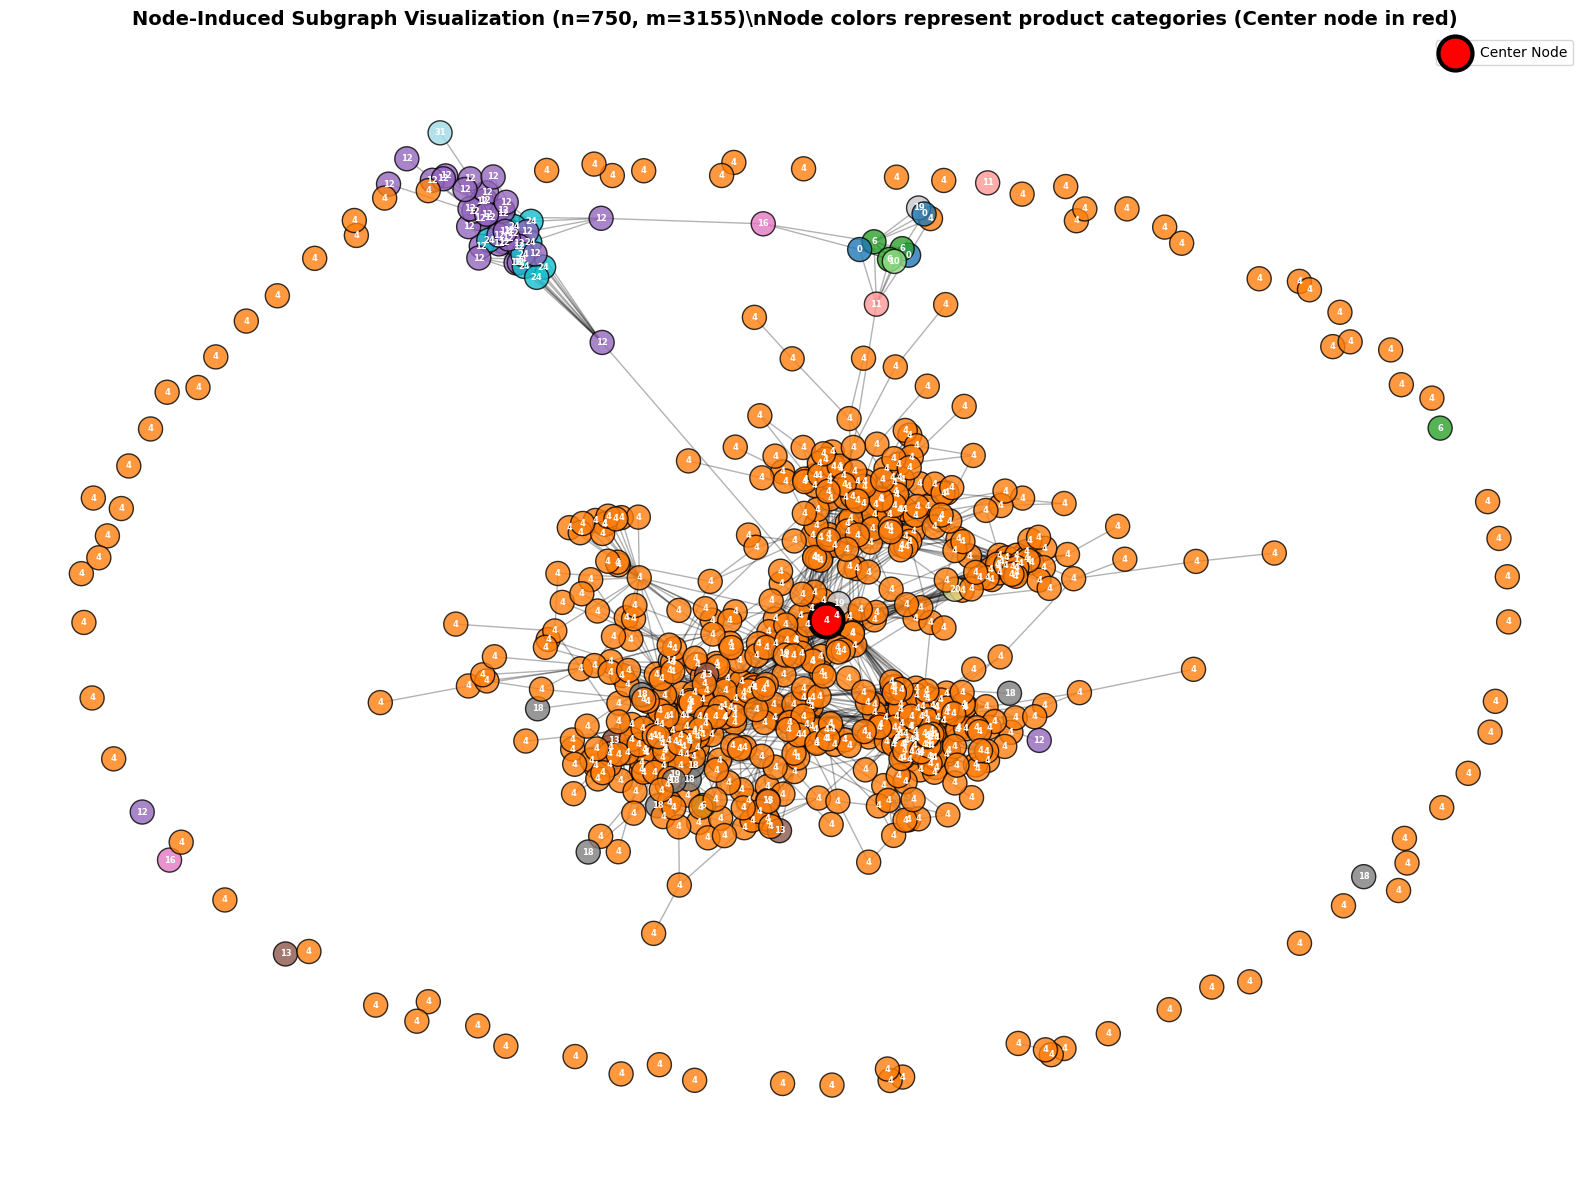

In [23]:
G_viz = nx.Graph()

# Ensure all nodes exist in the graph (including isolated ones)
num_local_nodes = len(subgraph_data['y'])
G_viz.add_nodes_from(range(num_local_nodes))

# Add edges
for i in range(subgraph_data['edge_index'].shape[1]):
    src, dst = int(subgraph_data['edge_index'][0, i]), int(subgraph_data['edge_index'][1, i])
    G_viz.add_edge(src, dst)

# Get node labels (categories) only for nodes present in G_viz
node_labels = {n: int(subgraph_data['y'][n]) for n in G_viz.nodes()}
unique_labels = sorted(list(set(node_labels.values())))

print(f"\nVisualizing node-induced subgraph:")
print(f"  - Nodes: {G_viz.number_of_nodes()}")
print(f"  - Edges: {G_viz.number_of_edges()}")
print(f"  - Unique categories: {len(unique_labels)}")

# Create color map
colors = plt.cm.tab20(np.linspace(0, 1, max(1, len(unique_labels))))
label_to_color = {label: colors[i % len(colors)] for i, label in enumerate(unique_labels)}
node_colors = [label_to_color[node_labels[node]] for node in G_viz.nodes()]

# Plot
plt.figure(figsize=(16, 12))
# Spring layout for all nodes (including isolated)
pos = nx.spring_layout(G_viz, k=0.5, iterations=50, seed=42)

nx.draw_networkx_nodes(
    G_viz, pos,
    node_color=node_colors,
    node_size=300,
    alpha=0.8,
    edgecolors='black',
    linewidths=1
)

nx.draw_networkx_edges(
    G_viz, pos,
    alpha=0.3,
    width=1
)

# Draw labels (category IDs); ensure labels only for nodes with positions
nx.draw_networkx_labels(
    G_viz, pos,
    labels=node_labels,
    font_size=6,
    font_color='white',
    font_weight='bold'
)

# Highlight center node if it exists
center_local = subgraph_data['center_node_local']
if center_local in G_viz.nodes:
    nx.draw_networkx_nodes(
        G_viz, pos,
        nodelist=[center_local],
        node_color='red',
        node_size=600,
        edgecolors='black',
        linewidths=3,
        label='Center Node'
    )

plt.title(
    f'Node-Induced Subgraph Visualization (n={G_viz.number_of_nodes()}, m={G_viz.number_of_edges()})\\n'
    'Node colors represent product categories (Center node in red)',
    fontsize=14, fontweight='bold'
)
plt.legend()
plt.axis('off')
plt.tight_layout()
plt.show()


## Generate Node Embeddings using 2-hop GNN

We'll use our trained GraphSAGE model to generate embeddings for nodes in the subgraph.
Since our model has 2 layers with neighbor sampling, it effectively captures 2-hop information.

In [24]:
print("Generating 2-hop Node Embeddings using trained GraphSAGE model...\n")

# Move subgraph to device
subgraph_x_device = subgraph_data['x'].to(device)
subgraph_edge_index_device = subgraph_data['edge_index'].to(device)

# Generate embeddings
model.eval()
with torch.no_grad():
    # Get embeddings from layer before classification
    embeddings = model.get_embeddings(subgraph_x_device, subgraph_edge_index_device)
    

# Move back to CPU
embeddings = embeddings.cpu()


print(f"Embeddings shape: {embeddings.shape}")
print(f"Embedding dimension: {embeddings.shape[1]}")
print(f"Number of nodes: {embeddings.shape[0]}")

# Compute embedding statistics
embedding_norms = torch.norm(embeddings, dim=1)
print(f"\nEmbedding Statistics:")
print(f"  - Mean norm: {embedding_norms.mean():.4f}")
print(f"  - Std norm: {embedding_norms.std():.4f}")
print(f"  - Min norm: {embedding_norms.min():.4f}")
print(f"  - Max norm: {embedding_norms.max():.4f}")


# Store embeddings
subgraph_data['embeddings'] = embeddings

print("\nEmbeddings generated successfully!")

Generating 2-hop Node Embeddings using trained GraphSAGE model...

Embeddings shape: torch.Size([750, 256])
Embedding dimension: 256
Number of nodes: 750

Embedding Statistics:
  - Mean norm: 42.7885
  - Std norm: 102.0184
  - Min norm: 4.3000
  - Max norm: 2614.9880

Embeddings generated successfully!
